# 기본 환경 설정.

In [ ]:
import os
import random
import time
import datetime
import argparse
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms as T
from tqdm.auto import tqdm
from collections import defaultdict
import os
import pandas as pd
import torch
import sys # <--- ADDED: sys 모듈 임포트 (OpLog 사용을 위해)
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# python /content/drive/MyDrive/codeit/mission7/src/z_mission7_06.py
#════════════════════════════════════════
# ▣ 환경 설정. 
#════════════════════════════════════════
BASE_DIR = r"D:\05.gdrive\codeit\mission7\data\pet_data"
#DBASE_DIR = "/content/drive/MyDrive/codeit/mission7/data/pet_data"
## 라인 구분 함수
def Lines(text="", count=100):
    print("═" * count)
    if text != "":
        print(f"{text}")
        print("═" * count)
def now_str():
    return datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def makedirs(d):
    os.makedirs(d, exist_ok=True)

def OpLog(log,bLines=True):
    if bLines:
        Lines(f"[{now_str()}]{log}")
    # 호출한 함수 이름 가져오기
    # sys._getframe(1)은 OpLog을 호출한 함수의 프레임. 
    try:
        caller_name = sys._getframe(1).f_code.co_name
    except Exception:
        caller_name = "UnknownFunction"
        
    # 3. 로그 파일명 및 내용 포맷팅
    log_filename = f"{BASE_DIR}/op_log.txt"
    log_content = f"[{now_str()}] {caller_name}: {log}\n"
    # 4. 파일에 로그 추가 (append)
    try:
        # 'a' 모드는 파일이 없으면 생성하고, 있으면 기존 내용에 추가.
        with open(log_filename, 'a', encoding='utf-8') as f:
            f.write(log_content)
    except Exception as e:
        print(f"로그 파일 쓰기 오류 발생: {e}")
OpLog("Program started.",bLines=True)


#════════════════════════════════════════
# ▣ 메타 정보 클래스
#════════════════════════════════════════
class MyMeta():
    def __init__(self):
        # 1. 내부 변수는 앞에 _(언더스코어)를 붙여서 '내부용'임을 표시합니다.
        self._base_dir = BASE_DIR
        self._device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # 경로 설정
        self._trainval_file = os.path.join(self._base_dir, "annotations", "annotations", "trainval.txt")
        self._test_file = os.path.join(self._base_dir, "annotations", "annotations", "test.txt")
        self._image_dir = os.path.join(self._base_dir, "images", "images")
        self._xml_dir = os.path.join(self._base_dir, "annotations", "annotations", "xmls")
        self._xml_files = [file for file in os.listdir(self._xml_dir) if file.endswith(".xml")]
        self._num_workers = 0  # 데이터 로더에 사용할 워커 수
        # 데이터프레임 로드
        try:
            self._df_trainval = pd.read_csv(self._trainval_file, sep="\s+", header=None)
            self._df_trainval.columns = ["Image", "ClassID", "Species", "BreedID"]
            
            self._df_test = pd.read_csv(self._test_file, sep="\s+", header=None)
            self._df_test.columns = ["Image", "ClassID", "Species", "BreedID"]
        except FileNotFoundError:
            print("파일을 찾을 수 없습니다. 경로를 확인해주세요.")
            self._df_trainval = None
            self._df_test = None
        self._ssd_weights_enum_available = False
        ## Try to import SSD weights enum support
        try:
            from torchvision.models.detection.ssd import SSD300_VGG16_Weights
            self._ssd_weights_enum_available = True
        except Exception:
            pass


    # === Properties (외부에서는 변수처럼 사용) ===
    @property
    def base_dir(self):
        return self._base_dir

    @property
    def device(self):
        return self._device

    @property
    def trainval_file(self):
        return self._trainval_file

    @property
    def test_file(self):
        return self._test_file
    
    @property
    def image_dir(self):
        return self._image_dir
    
    @property
    def xml_dir(self):
        return self._xml_dir

    @property
    def df_trainval(self):
        return self._df_trainval
    
    @property
    def df_test(self):
        return self._df_test

    @property
    def num_workers(self):
        return self._num_workers
    
    @property
    def ssd_weights_enum_available(self):
        return self._ssd_weights_enum_available

    @property
    def xml_files(self):
        return self._xml_files
    
## IoU 계산 함수
## 두 박스의 좌표는 (xmin, ymin, xmax, ymax) 형식으로 전달
## 반환값: IoU 값 (0.0 ~ 1.0)
## 예: boxA = [50, 50, 150, 150], boxB = [100, 100, 200, 200]
## iou = iou_box(boxA, boxB)
## 두 박스가 겹치는 영역의 넓이를 두 박스의 합집합 넓이로 나눈 값
def iou_box(boxA, boxB):
    xa1, ya1, xa2, ya2 = boxA
    xb1, yb1, xb2, yb2 = boxB
    inter_x1 = max(xa1, xb1)
    inter_y1 = max(ya1, yb1)
    inter_x2 = min(xa2, xb2)
    inter_y2 = min(ya2, yb2)
    inter_w = max(0, inter_x2 - inter_x1)
    inter_h = max(0, inter_y2 - yb1)
    inter_area = inter_w * inter_h
    areaA = max(0, xa2 - xa1) * max(0, ya2 - ya1)
    areaB = max(0, xb2 - xb1) * max(0, yb2 - yb1)
    union = areaA + areaB - inter_area
    return inter_area / union if union > 0 else 0.0

Lines("Define Utility Function.")

## 테스트 함수.
def Test_Util_Functions():
    # Train/Test 메타 정보 읽기
    meta = MyMeta()
    df_trainval = meta.df_trainval
    df_test = meta.df_test
    Lines(f"TrainVal samples: {len(df_trainval)}")
    Lines(f"Test samples: {len(df_test)}")
    print(f"XML 파일 개수: {len(meta.xml_files)}")
    # IoU 테스트
    boxA = [50, 50, 150, 150]
    boxB = [100, 100, 200, 200]
    iou = iou_box(boxA, boxB)
    Lines(f"IoU between boxA and boxB: {iou:.4f}")
    
    print(df_trainval.shape)
    df_trainval.head()
    print(df_test.shape)
    df_test.head()
    df_trainval['Species'].value_counts()
    df_test['Species'].value_counts()
    # Train과 Validation에 사용될 이미지 파일 이름 리스트 생성
    trainval_list = df_trainval['Image'].tolist()

    image_dir = meta.image_dir
    # Test에 사용될 이미지 파일 이름 리스트 생성
    test_list = df_test['Image'].tolist()
    # Train 데이터에서 예제 이미지 불러오기
    train_example_image_name = df_trainval["Image"].iloc[0]
    train_image_path = os.path.join(image_dir, f"{train_example_image_name}.jpg")

    # 이미지 읽기
    train_image = cv2.imread(train_image_path)
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)

    # Train 이미지 출력
    plt.imshow(train_image)
    plt.title(f"Train Image: {train_example_image_name}")
    plt.axis("off")
    plt.show()
    # Test 데이터에서 예제 이미지 불러오기
    test_example_image_name = df_test["Image"].iloc[0]
    test_image_path = os.path.join(image_dir, f"{test_example_image_name}.jpg")

    # 이미지 읽기
    test_image = cv2.imread(test_image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Test 이미지 출력
    plt.imshow(test_image)
    plt.title(f"Test Image: {test_example_image_name}")
    plt.axis("off")
    plt.show()
    xml_dir = meta.xml_dir
    xml_list = [os.path.splitext(file)[0] for file in os.listdir(xml_dir) if file.endswith(".xml")]

    # Train 이미지에 대해 XML 파일이 없는 경우 확인
    missing_xml = [image for image in trainval_list if image not in xml_list]

    # Train 이미지에 대해 XML 파일이 있는 경우 확인
    trainval_list = [image for image in trainval_list if image in xml_list]

    # 결과 출력
    print(f"XML 파일이 없는 Train 이미지 수: {len(missing_xml)}")
    print(missing_xml)
   
Test_Util_Functions()

d:\01.project\CodeIt\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

#════════════════════════════════════════
# ▣ Xml 파싱 테스트 함수 
#═══════════════════════════════════════
def Test_xml_Parsing():
    meta = MyMeta()
    xml_dir = meta.xml_dir
    # 예제 XML 파일 경로
    xml_files =  [f for f in os.listdir(xml_dir) if f.endswith(".xml")]

    example_xml_file = os.path.join(xml_dir, xml_files[0])

    # XML 파일 읽기 및 파싱
    tree = ET.parse(example_xml_file)
    root = tree.getroot()

    # 재귀적으로 모든 태그와 데이터 출력 함수
    def print_all_elements(element, indent=""):
        print(f"{indent}{element.tag}: {element.text}")
        for child in element:
            print_all_elements(child, indent + "  ")

    # XML 구조 탐색
    print_all_elements(root)
    # XML 파일에서 Bounding Box와 클래스 정보 추출
    for obj in root.findall("object"):
        class_name = obj.find("name").text  # 클래스 이름
        bndbox = obj.find("bndbox")
        x_min = int(bndbox.find("xmin").text)
        y_min = int(bndbox.find("ymin").text)
        x_max = int(bndbox.find("xmax").text)
        y_max = int(bndbox.find("ymax").text)
        print(f"Class: {class_name}, Bounding Box: ({x_min}, {y_min}, {x_max}, {y_max})")
Test_xml_Parsing()

annotation: None
  folder: OXIIIT
  filename: Abyssinian_1.jpg
  source: None
    database: OXFORD-IIIT Pet Dataset
    annotation: OXIIIT
    image: flickr
  size: None
    width: 600
    height: 400
    depth: 3
  segmented: 0
  object: None
    name: cat
    pose: Frontal
    truncated: 0
    occluded: 0
    bndbox: None
      xmin: 333
      ymin: 72
      xmax: 425
      ymax: 158
    difficult: 0
Class: cat, Bounding Box: (333, 72, 425, 158)


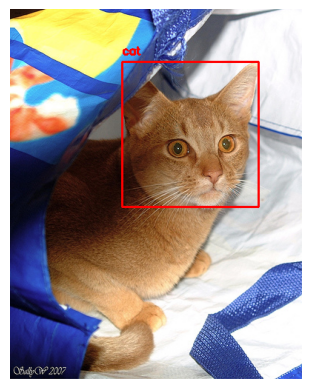

In [23]:

#════════════════════════════════════════
# ▣ 객체 검출 시각화 테스트 함수 
#════════════════════════════════════════
## XML 파일에서 어노테이션 정보를 추출하는 함수
def GetAnnotations():
    meta = MyMeta()
    xml_files = [file for file in os.listdir(meta.xml_dir) if file.endswith(".xml")]

    annotations = []
    for xml_file in xml_files:
        xml_path = os.path.join(meta.xml_dir, xml_file)
        tree = ET.parse(xml_path)
        root = tree.getroot()

        image_name = root.find("filename").text  # 이미지 파일 이름

        for obj in root.findall("object"):
            class_name = obj.find("name").text
            bndbox = obj.find("bndbox")
            x_min = int(bndbox.find("xmin").text)
            y_min = int(bndbox.find("ymin").text)
            x_max = int(bndbox.find("xmax").text)
            y_max = int(bndbox.find("ymax").text)

            annotations.append({
                "image": image_name,
                "class": class_name,
                "bbox": [x_min, y_min, x_max, y_max]
            })
    return annotations

## 객체 검출 시각화 테스트 함수
def ViewObjectDectection():
    meta = MyMeta()
    annotations = GetAnnotations()
    # Train 데이터에서 예제 이미지 불러오기
    train_example_image_name = meta.df_trainval["Image"].iloc[0]
    train_image_path = os.path.join(meta.image_dir, f"{train_example_image_name}.jpg")

    # 이미지 읽기
    image = cv2.imread(train_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 해당 이미지의 어노테이션 가져오기
    annotations = [anno for anno in annotations if anno["image"] == f"{train_example_image_name}.jpg"]

    # Bounding Box 그리기
    for anno in annotations:
        x_min, y_min, x_max, y_max = anno["bbox"]
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)  # 빨간색 박스
        cv2.putText(image, anno["class"], (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # 시각화
    plt.imshow(image)
    plt.axis("off")
    plt.show()
ViewObjectDectection()

### 객체 탐지용 데이터셋 클래스

In [ ]:

#════════════════════════════════════════
# ▣ 객체 탐지용 데이터셋 클래스
## 이 클래스는 [제각각인 크기의 원본 사진과 XML 정보]를 받아서 
## SSD 모델이 학습할 수 있는 300x300 크기의 이미지와 
## 그에 맞게 조정된 박스 좌표로 변환하여 공급해 주는 공급책 역할
#════════════════════════════════════════
class PetDetectionDataset(Dataset):
    def __init__(self, image_list: List[str], image_dir: str, xml_dir: str, transform=None, target_size=300):
        self.image_dir = image_dir
        self.xml_dir = xml_dir
        ### 파일 이름 리스트에서 확장자 제거
        self.image_list = [os.path.splitext(x)[0] for x in image_list]
        self.transform = transform  # should include Resize to (target_size, target_size) OR None
        self.target_size = target_size
        # 유효성 검사.(필터링)
        # jpg 파일과 xml 파일이 모두 존재하는 항목만 남김
        filtered = []
        for base in self.image_list:
            if os.path.exists(os.path.join(self.xml_dir, base + ".xml")) and os.path.exists(os.path.join(self.image_dir, base + ".jpg")):
                filtered.append(base)
        self.image_list = filtered
        OpLog(f"Detection dataset initialized. Original size={len(image_list)} Filtered size={len(self.image_list)}", bLines=False) # <--- ADDED LOG

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        base = self.image_list[idx]
        img_path = os.path.join(self.image_dir, base + ".jpg")
        xml_path = os.path.join(self.xml_dir, base + ".xml")
        ## 이미지 로드.
        img = Image.open(img_path).convert("RGB")
        W, H = img.size

        # parse xml
        boxes = []
        labels = []
        tree = ET.parse(xml_path)
        root = tree.getroot()
        ## 객체별로 바운딩 박스와 라벨 추출.
        for obj in root.findall("object"):
            name = obj.find("name").text.lower()
            bnd = obj.find("bndbox")
            xmin = float(bnd.find("xmin").text)
            ymin = float(bnd.find("ymin").text)
            xmax = float(bnd.find("xmax").text)
            ymax = float(bnd.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])
            # map to 1=cat,2=dog (we keep these labels; SSD expects labels starting from 1)
            # 라벨 매핑.
            if "cat" in name:
                labels.append(1)
            else:
                labels.append(2)
        boxes = np.array(boxes, dtype=np.float32) if len(boxes)>0 else np.zeros((0,4), dtype=np.float32)
        labels = np.array(labels, dtype=np.int64) if len(labels)>0 else np.zeros((0,), dtype=np.int64)

        # apply transforms: if transform is resize to (target_size,target_size), scale boxes accordingly
        # 객체 탐지에서는 이미지만 줄이면 안되고 바운딩 박스 좌표도 같이 조정해줘야 함.
        if self.transform is not None:
            # We assume transform contains resize to target_size as first op OR is T.Compose with Resize
            # To be safe, we do a simple resize float scaling ourselves (resize keeps aspect -> use exact scaling)
            # Resize image to target_size x target_size
            # 이미지 리사이즈 조정.
            img_resized = img.resize((self.target_size, self.target_size))
            # 스케일 비율 계산.
            sx = self.target_size / W
            sy = self.target_size / H
            # 바운드 좌표 스케일 조정.(비율에 맞게)
            if boxes.shape[0] > 0:
                boxes_scaled = boxes.copy()
                boxes_scaled[:, 0] = boxes[:, 0] * sx
                boxes_scaled[:, 1] = boxes[:, 1] * sy
                boxes_scaled[:, 2] = boxes[:, 2] * sx
                boxes_scaled[:, 3] = boxes[:, 3] * sy
            else:
                boxes_scaled = boxes
            # then apply any additional transforms (ToTensor, Normalize, etc.)
            # 이미지 텐서 변환.
            if isinstance(self.transform, T.Compose):
                # build a temporary compose that expects PIL image only (we already handled resize)
                # find last part that includes ToTensor and Normalize — apply entire compose to resized image
                img_tensor = self.transform(img_resized)
            else:
                img_tensor = T.ToTensor()(img_resized)
            target = {
                "boxes": torch.tensor(boxes_scaled, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx])
            }
            return img_tensor, target
        else:
            # fallback: return raw tensor resized
            img_resized = img.resize((self.target_size, self.target_size))
            img_tensor = T.ToTensor()(img_resized)
            target = {
                "boxes": torch.tensor(boxes, dtype=torch.float32),
                "labels": torch.tensor(labels, dtype=torch.int64),
                "image_id": torch.tensor([idx])
            }
            return img_tensor, target

# collate fn for detection (list of tuples -> tuple of lists)
def detection_collate_fn(batch):
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return images, targets
Lines("PetDetectionDataset class defined.")

════════════════════════════════════════════════════════════════════════════════════════════════════
PetDetectionDataset class defined.
════════════════════════════════════════════════════════════════════════════════════════════════════


### 

In [ ]:
#════════════════════════════════════════
# ▣ VOC 형식의 XML 어노테이션 파일에서 객체 이름과 바운딩 박스 좌표를 추출하는 함수
## 출력.
## names = ["cat", "dog", ...]
## boxes = [[xmin, ymin, xmax, ymax], ...]
#════════════════════════════════════════
def parse_xml_boxes(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    names = []
    for obj in root.findall("object"):
        name = obj.find("name").text.strip()
        bnd = obj.find("bndbox")
        xmin = int(float(bnd.find("xmin").text))
        ymin = int(float(bnd.find("ymin").text))
        xmax = int(float(bnd.find("xmax").text))
        ymax = int(float(bnd.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
        names.append(name)
    return names, boxes

#════════════════════════════════════════
# ▣ VOC 형식의 XML 어노테이션 파일에서 객체 이름과 바운딩 박스 좌표를 추출하는 함수
## 출력.
'''
[
  {'img': 'path/to/img1.jpg', 'bbox': [xmin,ymin,xmax,ymax], 'label': 1},  # cat
  {'img': 'path/to/img2.jpg', 'bbox': [xmin,ymin,xmax,ymax], 'label': 2},  # dog
  {'img': 'path/to/img3.jpg', 'bbox': [x1,y1,x2,y2], 'label': 0},          # background
  ...
]
'''
#════════════════════════════════════════

def generate_bbox_samples_from_xml(df_trainval, df_test, image_dir, xml_dir, bg_per_image=1, seed=42):
    random.seed(seed); np.random.seed(seed)
    ## 이미지 이름과 종(species) 매핑 생성
    df_all = pd.concat([df_trainval, df_test], ignore_index=True)
    img2species = dict(zip(df_all['Image'].astype(str), df_all['Species'].astype(int)))  # 1=cat,2=dog

    xml_files = [f for f in os.listdir(xml_dir) if f.endswith(".xml")]
    samples = []

    ## XML 순회 및 전경 추출.
    for xml_file in tqdm(xml_files, desc="parse xml"):
        base = os.path.splitext(xml_file)[0]
        xml_path = os.path.join(xml_dir, xml_file)
        img_path = os.path.join(image_dir, base + ".jpg")
        if not os.path.exists(img_path):
            continue
        names, boxes = parse_xml_boxes(xml_path)
        # foreground per bounding box
        for name, box in zip(names, boxes):
            # determine label: prefer image-level mapping
            sp = img2species.get(base, None)
            if sp is not None:
                label = int(sp)  # 1 or 2
            else:
                label = 1 if 'cat' in name.lower() else 2
            samples.append({'img': img_path, 'bbox': box, 'label': label})
        # background crops
        try:
            im = Image.open(img_path).convert("RGB")
            W, H = im.size
        except Exception:
            continue
        # target crop size similar to average bbox
        if len(boxes) > 0:
            widths = [b[2]-b[0] for b in boxes]
            heights = [b[3]-b[1] for b in boxes]
            ## 평균 박스 크기 계산.(배경도 객체랑 비슷한 크기로 자르기 위해.)
            cw = int(np.mean(widths)); ch = int(np.mean(heights))
            cw = max(32, min(cw, W//2)); ch = max(32, min(ch, H//2))
        else:
            cw = max(32, min(W//4, 256)); ch = max(32, min(H//4, 256))
        created = 0; attempts = 0
        max_attempts = 50 * bg_per_image
        while created < bg_per_image and attempts < max_attempts:
            attempts += 1
            # 랜덤 크롭 시도.
            # 랜덤 좌표 생성.
            x1 = random.randint(0, max(0, W - cw))
            y1 = random.randint(0, max(0, H - ch))
            x2 = x1 + cw; y2 = y1 + ch
            crop = [x1,y1,x2,y2]
            # 겹치는지 검사.
            ok = True
            for b in boxes:
                if iou_box(crop, b) >= 0.1:
                    ok = False; break
            if ok:
                samples.append({'img': img_path, 'bbox': crop, 'label': 0})
                created += 1
    random.shuffle(samples)
    OpLog(f"Classification samples generated: Total={len(samples)} (BG_per_img={bg_per_image})", bLines=False) # <--- ADDED LOG
    return samples
